In [1]:
import numpy as np
import pandas as pd
import os
import sys
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from utils import *
from model.model import build_model, heteroskedastic_loss, save_model, load_model
from train import predict

np.random.seed(4444)  # random seed for train data shuffling

# Loading data

In [2]:
in_frames=8
out_frames=15
diff_fn=get_diff_array_v2
normalize=False


#DATA
#odometry
odometry_pickle_path_test = 'data/pickles/test_odometry.p'
odometry_pickle_path_train = 'data/pickles/train_odometry.p'

# odometry_x_test, odometry_y_test = get_odometry('data/tracks/tracks_test.h5', 'data/odometry/test',
#                                                 in_frames, out_frames)
# odometry_x_train, odometry_y_train = get_odometry('data/tracks/tracks_train.h5', 'data/odometry/train',
#                                                   in_frames, out_frames)

# save_pickle(odometry_pickle_path_test, (odometry_x_test, odometry_y_test))
# save_pickle(odometry_pickle_path_train, (odometry_x_train, odometry_y_train))

odometry_x_test, odometry_y_test = load_pickle(odometry_pickle_path_test)
odometry_x_train, odometry_y_train = load_pickle(odometry_pickle_path_train)
print('[+] Odometry loaded train shapes x: %s y: %s' % (odometry_x_train.shape, odometry_y_train.shape))


#loading tracks
tracks_pickle_path_test = 'data/pickles/test_tracks.p'
tracks_pickle_path_train = 'data/pickles/train_tracks.p'
tracks_pickle_path_inverse_train = 'data/pickles/inverse_train_tracks.p'

# test_x, test_y = get_data_set(in_frames, out_frames, 'data/tracks/tracks_test.h5', diff_fn=get_diff_array_v2)
# train_x, train_y = get_data_set(in_frames, out_frames, 'data/tracks/tracks_train.h5', diff_fn=get_diff_array_v2)
# inverse_train_x, inverse_train_y = get_data_set(in_frames, out_frames, 'data/tracks/tracks_train.h5',
#                                                 diff_fn=get_diff_array_v2)

# save_pickle(tracks_pickle_path_test, (test_x, test_y))
# save_pickle(tracks_pickle_path_train, (train_x, train_y))
# save_pickle(tracks_pickle_path_inverse_train, (inverse_train_x, inverse_train_y))

test_x, test_y = load_pickle(tracks_pickle_path_test)
train_x, train_y = load_pickle(tracks_pickle_path_train)
inverse_train_x, inverse_train_y = load_pickle(tracks_pickle_path_inverse_train)
print('[+] Tracks loaded train shapes x: %s y: %s' % (train_x.shape, train_y.shape))

# concatenate train inverse bbs with normal bbs
train_x = np.concatenate([train_x, inverse_train_x], axis=0)
train_y = np.concatenate([train_y, inverse_train_y], axis=0)

#concatenate odometry with itself because inverse bbs were added
inverse_odometry_x_train = np.copy(odometry_x_train)
inverse_odometry_x_train[:, :, 1] = inverse_odometry_x_train[:, :, 1] * -1 #iversion of steering angle
inverse_odometry_y_train = np.copy(odometry_y_train)
inverse_odometry_y_train[:, :, 1] = inverse_odometry_y_train[:, :, 1] * -1

odometry_x_train = np.concatenate([odometry_x_train, inverse_odometry_x_train], axis=0)
odometry_y_train = np.concatenate([odometry_y_train, inverse_odometry_y_train], axis=0)


#concatanete bbs with odometry
test_x = np.concatenate([test_x, odometry_x_test], axis=-1)
train_x = np.concatenate([train_x, odometry_x_train], axis=-1)

#apply permutation on train data
train_x, train_y = permutation(train_x, train_y)

#for dev
# train_x, train_y = train_x[:1000], train_y[:1000]
# test_x, test_y = test_x[:100], test_y[:100]

[+] Odometry loaded train shapes x: (40606, 7, 2) y: (40606, 15, 2)
[+] Tracks loaded train shapes x: (40606, 7, 4) y: (40606, 15, 4)


# Train

In [3]:
batch_size=512
epochs=15
mc_samples = 10
validation_split=0.2 # do callback to evaluate validation dataset with mc_sampling
base_path='data/model'

# Train unit variational dropout combined uncertainty 

In [4]:
unit_dropout_model_name = 'unit_dp_model'
unit_dropout_model_kwargs = {
        'input_shape': train_x.shape[1:],
        'output_dim': train_y.shape[-1],
        'num_prediction_steps': 15,
        'weight_dropout': 0.,
        'unit_dropout': 0.35,
        'lam': 0.0001,
        'loss_fn': heteroskedastic_loss,
        'predict_variance':  True,
        'use_mc_dropout': True,
    }

unit_dropout_model = build_model(**unit_dropout_model_kwargs)
unit_dp_model_history = unit_dropout_model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs,
                                               validation_split=validation_split)

# saving weights and model_kwargs separately
save_model(os.path.join(base_path, unit_dropout_model_name), unit_dropout_model, unit_dropout_model_kwargs)

Train on 64969 samples, validate on 16243 samples
Epoch 1/15
64969/64969 [==============================] - 270s 4ms/sample - loss: 3.4277 - mse_metric: 95.1190 - mean_variance: 3.9591 - val_loss: 2.5244 - val_mse_metric: 85.2019 - val_mean_variance: 3.8824
Epoch 2/15
64969/64969 [==============================] - 272s 4ms/sample - loss: 2.4600 - mse_metric: 74.6069 - mean_variance: 3.6762 - val_loss: 2.4265 - val_mse_metric: 65.5371 - val_mean_variance: 3.5588
Epoch 3/15
64969/64969 [==============================] - 261s 4ms/sample - loss: 2.3915 - mse_metric: 62.5742 - mean_variance: 3.5554 - val_loss: 2.3923 - val_mse_metric: 59.5306 - val_mean_variance: 3.6296
Epoch 4/15
64969/64969 [==============================] - 268s 4ms/sample - loss: 2.3590 - mse_metric: 58.0895 - mean_variance: 3.5022 - val_loss: 2.3484 - val_mse_metric: 56.2709 - val_mean_variance: 3.4496
Epoch 5/15
64969/64969 [==============================] - 265s 4ms/sample - loss: 2.3365 - mse_metric: 55.6070 - mean_

# Train weight variational dropout model

In [5]:
weight_dropout_model_name = 'weight_dp_model'
weight_dropout_model_kwargs = {
    'input_shape': train_x.shape[1:],
    'output_dim': train_y.shape[-1],
    'num_prediction_steps': 15,
    'weight_dropout': 0.35,
    'unit_dropout': 0.,
    'lam': 0.0001,
    'loss_fn': heteroskedastic_loss,
    'predict_variance': True,
    'use_mc_dropout': True,
}

weight_dropout_model = build_model(**weight_dropout_model_kwargs)
weight_dp_model_history = weight_dropout_model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs,
                                                   validation_split=validation_split)

# saving weights and model_kwargs separately
save_model(os.path.join(base_path, weight_dropout_model_name), weight_dropout_model, weight_dropout_model_kwargs)

Train on 64969 samples, validate on 16243 samples
Epoch 1/15
64969/64969 [==============================] - 238s 4ms/sample - loss: 5.4853 - mse_metric: 100.5557 - mean_variance: 4.0026 - val_loss: 2.6758 - val_mse_metric: 98.9981 - val_mean_variance: 4.0735
Epoch 2/15
64969/64969 [==============================] - 211s 3ms/sample - loss: 2.5989 - mse_metric: 98.9894 - mean_variance: 3.9382 - val_loss: 2.5564 - val_mse_metric: 96.2865 - val_mean_variance: 3.8766
Epoch 3/15
64969/64969 [==============================] - 223s 3ms/sample - loss: 2.5192 - mse_metric: 93.7699 - mean_variance: 3.7971 - val_loss: 2.4981 - val_mse_metric: 86.7341 - val_mean_variance: 3.8019
Epoch 4/15
64969/64969 [==============================] - 215s 3ms/sample - loss: 2.4498 - mse_metric: 79.1368 - mean_variance: 3.6822 - val_loss: 2.4284 - val_mse_metric: 70.3204 - val_mean_variance: 3.5405
Epoch 5/15
64969/64969 [==============================] - 213s 3ms/sample - loss: 2.3941 - mse_metric: 66.4863 - mean

# Train no variational dropout model

In [6]:
no_dropout_model_name = 'no_dp_model'
no_dropout_model_kwargs = {
    'input_shape': train_x.shape[1:],
    'output_dim': train_y.shape[-1],
    'num_prediction_steps': 15,
    'weight_dropout': 0.,
    'unit_dropout': 0.10,
    'lam': 0.0001,
    'loss_fn': 'mse',
    'predict_variance': False,
    'use_mc_dropout': False,
}

no_dropout_model = build_model(**no_dropout_model_kwargs)
no_dp_model_history = no_dropout_model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs,
                               validation_split=validation_split)

# saving weights and model_kwargs separately
save_model(os.path.join(base_path, no_dropout_model_name), no_dropout_model, no_dropout_model_kwargs)

Train on 64969 samples, validate on 16243 samples
Epoch 1/15
64969/64969 [==============================] - 220s 3ms/sample - loss: 54.2230 - mse: 54.0905 - val_loss: 46.8609 - val_mse: 46.7187
Epoch 2/15
64969/64969 [==============================] - 214s 3ms/sample - loss: 46.2643 - mse: 46.1143 - val_loss: 45.4477 - val_mse: 45.2907
Epoch 3/15
64969/64969 [==============================] - 220s 3ms/sample - loss: 45.0331 - mse: 44.8703 - val_loss: 44.9243 - val_mse: 44.7563
Epoch 4/15
64969/64969 [==============================] - 215s 3ms/sample - loss: 44.4904 - mse: 44.3176 - val_loss: 44.4017 - val_mse: 44.2241
Epoch 5/15
64969/64969 [==============================] - 216s 3ms/sample - loss: 44.0079 - mse: 43.8254 - val_loss: 43.9919 - val_mse: 43.8052
Epoch 6/15
64969/64969 [==============================] - 221s 3ms/sample - loss: 43.6290 - mse: 43.4377 - val_loss: 43.3198 - val_mse: 43.1238
Epoch 7/15
64969/64969 [==============================] - 219s 3ms/sample - loss: 43.2

# Train results

In [7]:
train_mse = {
    unit_dropout_model_name: unit_dp_model_history.history['mse_metric'],
    weight_dropout_model_name: weight_dp_model_history.history['mse_metric'],
    no_dropout_model_name: no_dp_model_history.history['mse'],
    unit_dropout_model_name+'_valid': unit_dp_model_history.history['val_mse_metric'],
    weight_dropout_model_name+'_valid': weight_dp_model_history.history['val_mse_metric'],
    no_dropout_model_name+'_valid': no_dp_model_history.history['val_mse']
}

train_logvar = {
    unit_dropout_model_name: unit_dp_model_history.history['mean_variance'],
    weight_dropout_model_name: weight_dp_model_history.history['mean_variance'],
    unit_dropout_model_name+'_valid': unit_dp_model_history.history['val_mean_variance'],
    weight_dropout_model_name+'_valid': weight_dp_model_history.history['val_mean_variance'],
}
train_loss = {
    unit_dropout_model_name: unit_dp_model_history.history['loss'],
    weight_dropout_model_name: weight_dp_model_history.history['loss'],
    unit_dropout_model_name+'_valid': unit_dp_model_history.history['val_loss'],
    weight_dropout_model_name+'_valid': weight_dp_model_history.history['val_loss'],
#     no_dropout_model_name: no_dp_model_history.history['loss'],
#     no_dropout_model_name+'_valid': no_dp_model_history.history['val_loss']
}

[Text(0, 0.5, 'MSE'), Text(0.5, 0, 'Epochs')]

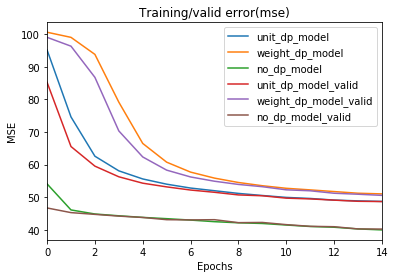

In [8]:
df_train_mse = pd.DataFrame(train_mse) 
ax = df_train_mse.plot(title='Training/valid error(mse)')
ax.set(xlabel='Epochs', ylabel='MSE')

[Text(0, 0.5, 'loss'), Text(0.5, 0, 'Epochs')]

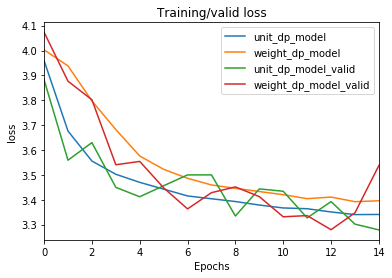

In [9]:
df_train_logvar = pd.DataFrame(train_logvar) 
ax = df_train_logvar.plot(title='Training/valid loss')
ax.set(xlabel='Epochs', ylabel='loss')

[Text(0, 0.5, 'loss'), Text(0.5, 0, 'Epochs')]

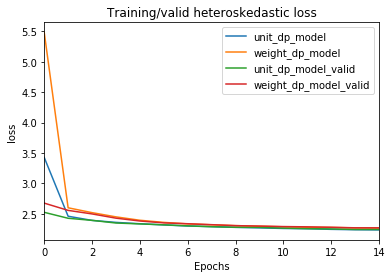

In [10]:
df_train_loss = pd.DataFrame(train_loss) 
ax = df_train_loss.plot(title='Training/valid heteroskedastic loss')
ax.set(xlabel='Epochs', ylabel='loss')

# Test

In [11]:
res_pred = {}
res_mse = {}
res_aletoric = {}
res_epistemic = {}
mc_samples = 10

# for evaluation purposes 
test_y = np.cumsum(test_y, axis=1) if diff_fn == get_diff_array_v2 else test_y

# Test unit dropout model

In [12]:
pred, aletoric, epistemic = predict(unit_dropout_model, test_x, predict_var=unit_dropout_model_kwargs['predict_variance'],
                                    use_cum_sum=True if diff_fn == get_diff_array_v2 else False,  mc_samples=mc_samples)
print(pred.shape)
res_pred[unit_dropout_model_name] = pred.copy()
res_aletoric[unit_dropout_model_name] = aletoric.copy()
res_epistemic[unit_dropout_model_name] = epistemic.copy()
res_mse[unit_dropout_model_name] = np.square(pred.copy() - test_y).mean()

print("[+] MSE: %f Aletoric_unc: %f Epistemic_unc: %f " %
      (res_mse[unit_dropout_model_name], aletoric.mean(), epistemic.mean()))

(21385, 15, 4)
[+] MSE: 615.742065 Aletoric_unc: 5.453925 Epistemic_unc: 0.521709 


# Test weight dropout model

In [13]:
pred, aletoric, epistemic = predict(weight_dropout_model, test_x, mc_samples=10,
                                        predict_var=weight_dropout_model_kwargs['predict_variance'],
                                        use_cum_sum=True if diff_fn == get_diff_array_v2 else False)

res_pred[weight_dropout_model_name] = pred.copy()
res_aletoric[weight_dropout_model_name] = aletoric.copy()
res_epistemic[weight_dropout_model_name] = epistemic.copy()
res_mse[weight_dropout_model_name] = np.square(pred.copy() - test_y).mean()

print("[+] MSE: %f Aletoric_unc: %f Epistemic_unc: %f " % 
      (res_mse[weight_dropout_model_name], aletoric.mean(), epistemic.mean()))

[+] MSE: 671.070496 Aletoric_unc: 6.303186 Epistemic_unc: 0.324876 


# Test no variational dropout model

In [14]:
pred = no_dropout_model.predict(test_x)
                                       
res_pred[no_dropout_model_name] = pred.copy()
# fill uncertainties with zeros
res_aletoric[no_dropout_model_name] = np.zeros_like(pred)
res_epistemic[no_dropout_model_name] = np.zeros_like(pred)
res_mse[no_dropout_model_name] = np.square(pred - test_y).mean()
print("[+] MSE: %f " % (res_mse[no_dropout_model_name]))

[+] MSE: 3133.428467 


# Test results visualisation

[Text(0, 0.5, 'MSE')]

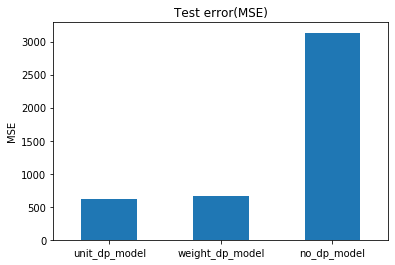

In [15]:
df_index = [k for k, v in res_mse.items()]
test_results = {
    'mse': [v for k, v in res_mse.items()],
    'aletoric_unc': [v.mean() for k, v in res_aletoric.items()],
    'epistemic_unc': [v.mean() for k, v in res_epistemic.items()]
}

df_test_results = pd.DataFrame(test_results, index=df_index)

ax = df_test_results['mse'].plot.bar(rot=0, title='Test error(MSE)')
ax.set(ylabel='MSE')

[Text(0, 0.5, 'Aletoric uncertainty(std)')]

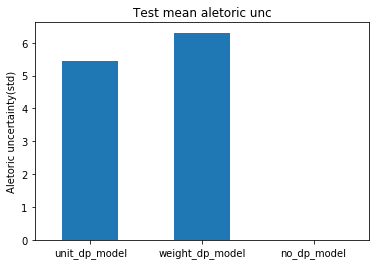

In [16]:
ax = df_test_results['aletoric_unc'].plot.bar(rot=0, title='Test mean aletoric unc')
ax.set(ylabel='Aletoric uncertainty(std)')

[Text(0, 0.5, 'Epistemic uncertainty(std)')]

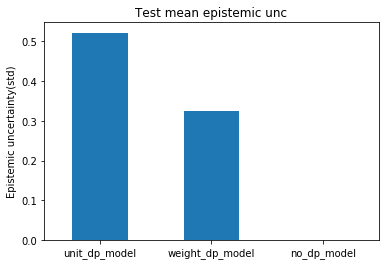

In [17]:
ax = df_test_results['epistemic_unc'].plot.bar(rot=0, title='Test mean epistemic unc')
ax.set(ylabel='Epistemic uncertainty(std)')

In [18]:
res_mse_per_timestep = dict([k, np.square(v - test_y).mean(axis=0).mean(axis=-1)] for k, v in res_pred.items())
res_aletoric_per_timestep = dict([k, v.mean(axis=0).mean(axis=-1)] for k, v in res_aletoric.items())
res_epistemic_per_timestep = dict([k, v.mean(axis=0).mean(axis=-1)] for k, v in res_epistemic.items())

[Text(0, 0.5, 'MSE'), Text(0.5, 0, 'Timestep')]

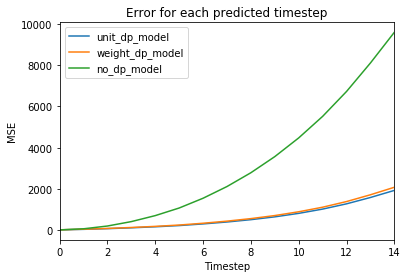

In [19]:
ax = pd.DataFrame(res_mse_per_timestep).plot(title='Error for each predicted timestep')
ax.set(xlabel='Timestep', ylabel='MSE')

[Text(0, 0.5, 'Aletoric uncertainty(std)'), Text(0.5, 0, 'Timestep')]

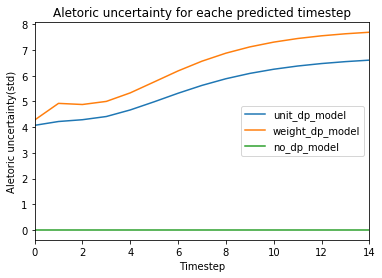

In [20]:
ax = pd.DataFrame(res_aletoric_per_timestep).plot(title='Aletoric uncertainty for eache predicted timestep')
ax.set(xlabel='Timestep', ylabel='Aletoric uncertainty(std)')

[Text(0, 0.5, 'Epistemic uncertainty(std)'), Text(0.5, 0, 'Timestep')]

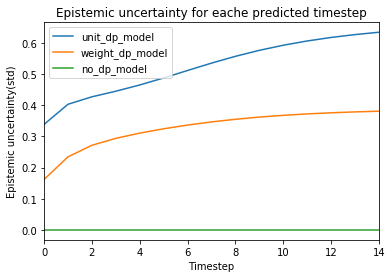

In [21]:
ax = pd.DataFrame(res_epistemic_per_timestep).plot(title='Epistemic uncertainty for eache predicted timestep')
ax.set(xlabel='Timestep', ylabel='Epistemic uncertainty(std)')

In [22]:
# mse trough timesteps
# bar chart of results mse and var(std)